In [1]:
# !pip install tqdm
# !pip install natsort

# https://github.com/Puayny/Autoencoder-image-similarity/blob/master/Autoencoder%2C%20MNIST%20dataset.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model
import matplotlib.pyplot as plt
from autoencoder_utils import *
from natsort import natsorted
import random, shutil, os
from tqdm import tqdm
from PIL import Image
import numpy as np
import pickle

Using TensorFlow backend.


In [2]:
whole_data = '/resources/image_dataset/whole_data/'
train_dataset_path = '/resources/image_dataset/train/'
test_dataset_path = '/resources/image_dataset/test/'

data = os.listdir(whole_data)
data = natsorted(data)
shuffled_date = random.sample(data, len(data))
train_data = shuffled_date[: int(0.8*len(data))]
test_data = shuffled_date[int(0.8*len(data)) :]

if not os.path.exists(train_dataset_path):
    os.makedirs(train_dataset_path)
    for each_image in tqdm(train_data):
        foo = Image.open(whole_data + each_image).convert('L')
        foo = foo.resize((128, 128),Image.ANTIALIAS)
        foo.save(train_dataset_path + each_image,optimize=True,quality=95)

if not os.path.exists(test_dataset_path):
    os.makedirs(test_dataset_path)
    for each_image in tqdm(test_data):
        foo = Image.open(whole_data + each_image).convert('L')
        foo = foo.resize((128, 128),Image.ANTIALIAS)
        foo.save(test_dataset_path + each_image,optimize=True,quality=95)

100%|██████████| 948/948 [00:40<00:00, 23.42it/s]


### Task did in above cell

1. Uploaded dataset
2. Random Shuffled data
3. Split dataset into train and test
4. Reducing Size to (128, 128) [Reason: Not much Computing Power.]
5. Saved in train and test in their respective folders

In [3]:
for each_image in tqdm(data):
    image = plt.imread(whole_data + each_image)
    if image.shape == (512, 512, 3):
        continue
    else:
        print(image.shape)

100%|██████████| 4738/4738 [01:10<00:00, 66.82it/s]


### Task did in above cell

1. Checking if any image size different from (512, 512, 3)

In [3]:
train = np.array([plt.imread(train_dataset_path + each_image) for each_image in tqdm(os.listdir(train_dataset_path))])
test = np.array([plt.imread(test_dataset_path + each_image) for each_image in tqdm(os.listdir(test_dataset_path))])
train = np.reshape(train, (len(train), 128, 128, 1)) / 255.
test = np.reshape(test, (len(test), 128, 128, 1)) / 255.
np.save('train.npy', train)
np.save('test.npy', test)

100%|██████████| 948/948 [00:03<00:00, 285.00it/s]


### Task did in above cell

1. Creating Numpy array of train and test images
2. Saving both into .npy files so that next time we can start from here
3. Reshaping image size from (128, 128) to (128, 128, 1)

# Can Start from here

In [2]:
train = np.load('train.npy')
test = np.load('test.npy')

In [3]:
autoencoder = Sequential()

input_shape = (128, 128, 1)
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2), padding='same')) #padding=same here, to maxpool 7*7 to 4*4
autoencoder.add(Conv2D(4, (1, 1), activation='sigmoid', padding='same', name='encoded_layer')) #sigmoid to convert all to values between 0 and 1, for comparison later on using binary_crossentropy
# at this point, encoded layer has shape (8, 8, 4)

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding= 'same', kernel_initializer='he_normal')) #no padding=same here, to convert 16*16 to 14*14
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 4)         292       
__________

### Task did in above cell

1. Model Architecture

In [4]:
epochs = 10
batch_size = 32
autoencoder.fit(train, train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(test, test))
autoencoder.save('autoencoder_avantari.h5')

Train on 3790 samples, validate on 948 samples
Epoch 1/10
3790/3790 [==============================] - 1178s 311ms/step - loss: 0.6598 - binary_crossentropy: 0.6598 - val_loss: 0.6382 - val_binary_crossentropy: 0.6382
Epoch 2/10
3790/3790 [==============================] - 1184s 312ms/step - loss: 0.6346 - binary_crossentropy: 0.6346 - val_loss: 0.6334 - val_binary_crossentropy: 0.6334
Epoch 3/10
3790/3790 [==============================] - 1179s 311ms/step - loss: 0.6317 - binary_crossentropy: 0.6317 - val_loss: 0.6318 - val_binary_crossentropy: 0.6318
Epoch 4/10
3790/3790 [==============================] - 1188s 313ms/step - loss: 0.6304 - binary_crossentropy: 0.6304 - val_loss: 0.6306 - val_binary_crossentropy: 0.6306
Epoch 5/10
3790/3790 [==============================] - 1182s 312ms/step - loss: 0.6295 - binary_crossentropy: 0.6295 - val_loss: 0.6300 - val_binary_crossentropy: 0.6300
Epoch 6/10
3790/3790 [==============================] - 1187s 313ms/step - loss: 0.6286 - binary_c

In [5]:
img_to_find_idx = 0

layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, img_to_find_idx, dataset=test, loss='binary_crossentropy')

### Task did in above cell

1. Took Encoder_layer output and tried to find similar images in that dimension.

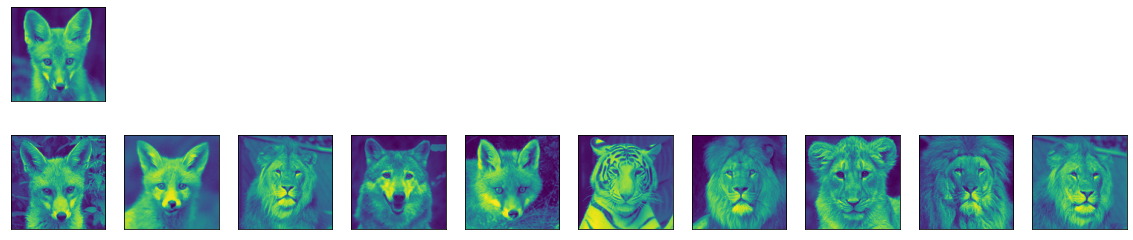

In [8]:
#show original image, n most similar images, n most dissimilar images
n = 10
image_dataset = test

plt.figure(figsize=(n*2, n/1.5))
img_shape = (128, 128,1)

#display original
display_single_subplot(image_dataset[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

# #display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(image_dataset[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)

### Task did in above cell

1. Plotted Image and it 10 similar images